In [1]:
import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
NeighborListFormat = partition.NeighborListFormat

from functools import partial
import time
from typing import List, Dict, Tuple, Callable, Optional

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = jnp.triu(jnp.where(dr<dr_cutoff, 1, 0)) - jnp.eye(R.shape[0],dtype=jnp.int32)
  index_list=jnp.dstack(jnp.meshgrid(jnp.arange(N), jnp.arange(N), indexing='ij'))

  i_s = jnp.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = jnp.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = jnp.transpose(jnp.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=jnp.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=jnp.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 2

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_pair.json")

In [4]:
coefficients = jnp.asarray(model.coefficients[1:])
knots = jnp.asarray(model.bspline_config.knots_map[('W','W')])

print(coefficients)
print(knots)

[ 6.43001157e+00  5.97354258e+00  5.06058796e+00  3.69113106e+00
  1.65205855e+00  9.23859147e-01  2.81258202e-01 -5.36413561e-03
 -1.65669972e-01 -2.39954884e-01 -2.77954263e-01 -2.80998799e-01
 -2.49653066e-01 -1.77409590e-01 -1.00099852e-01 -6.82599769e-02
 -2.00034440e-02 -3.28071234e-02 -3.43219435e-02 -3.43618259e-02
 -2.88400639e-02 -2.12175439e-02 -6.90983500e-04 -9.25139031e-03
 -8.08694792e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[1.5  1.5  1.5  1.5  1.66 1.82 1.98 2.14 2.3  2.46 2.62 2.78 2.94 3.1
 3.26 3.42 3.58 3.74 3.9  4.06 4.22 4.38 4.54 4.7  4.86 5.02 5.18 5.34
 5.5  5.5  5.5  5.5 ]


## Building neighbor list and data

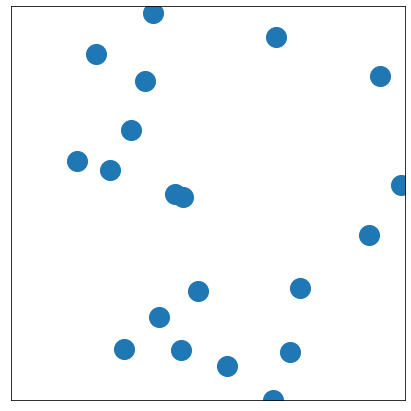

In [5]:
N = 20
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [6]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [7]:
species = onp.concatenate([onp.zeros(N//2), onp.ones(N-(N//2))])
rng = onp.random.default_rng()
rng.shuffle(species)
species = jnp.asarray(species, dtype=jnp.int16)
# print(species)
jnp.max(species)

DeviceArray(1, dtype=int16)

## Potential

In [8]:
from uf3.jax.potentials import uf2_neighbor

nf, ef = uf2_neighbor(displacement,box_size ,knots=knots, cutoff=5.5)

In [9]:
nbrs = nf.allocate(R)

In [10]:
from uf3.jax.potentials import uf2_pair

pair = uf2_pair(displacement, coefficients=coefficients, knots=knots)
print(pair(R))
print(ef(R, neighbor=nbrs, coefficients=coefficients, knots=knots))

-2.3293028603222643
-2.3293028603222643


In [11]:
coeff_dict = {}
coeff_dict[(0,0)] = coefficients
coeff_dict[(0,1)] = coefficients
coeff_dict[(1,1)] = coefficients

knot_dict = {}
knot_dict[(0,0)] = knots
knot_dict[(0,1)] = knots
knot_dict[(1,1)] = knots

In [12]:
nf, ef = uf2_neighbor(displacement, box_size, species=species, knots=knot_dict, cutoff=5.5)
nbrs = nf.allocate(R)

In [13]:
print(ef(R, neighbor=nbrs, coefficients=coeff_dict))

-2.3293028603222647
